### Teste do efeito do pooling na vizualização dos filtros 

In [1]:
%%capture

#Imaporta a rede VGG19 ja treinada
from keras.applications.vgg19 import VGG19
model = VGG19()

#Pre-processamento da imagem
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

#Biblioteca para operar sobre o modelo
from keras import models

import numpy as np
from math import sqrt
from random import randint
from numpy import argmax

#Biblioteca do SOM
from minisom import MiniSom

#Bibliotecas do PCA
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
j=0
for i in model.layers[1:]:
    print(j, ' ', i.name, ' - ', i.output_shape)
    j+=1

0   block1_conv1  -  (None, 224, 224, 64)
1   block1_conv2  -  (None, 224, 224, 64)
2   block1_pool  -  (None, 112, 112, 64)
3   block2_conv1  -  (None, 112, 112, 128)
4   block2_conv2  -  (None, 112, 112, 128)
5   block2_pool  -  (None, 56, 56, 128)
6   block3_conv1  -  (None, 56, 56, 256)
7   block3_conv2  -  (None, 56, 56, 256)
8   block3_conv3  -  (None, 56, 56, 256)
9   block3_conv4  -  (None, 56, 56, 256)
10   block3_pool  -  (None, 28, 28, 256)
11   block4_conv1  -  (None, 28, 28, 512)
12   block4_conv2  -  (None, 28, 28, 512)
13   block4_conv3  -  (None, 28, 28, 512)
14   block4_conv4  -  (None, 28, 28, 512)
15   block4_pool  -  (None, 14, 14, 512)
16   block5_conv1  -  (None, 14, 14, 512)
17   block5_conv2  -  (None, 14, 14, 512)
18   block5_conv3  -  (None, 14, 14, 512)
19   block5_conv4  -  (None, 14, 14, 512)
20   block5_pool  -  (None, 7, 7, 512)
21   flatten  -  (None, 25088)
22   fc1  -  (None, 4096)
23   fc2  -  (None, 4096)
24   predictions  -  (None, 1000)


In [3]:
%%capture
# Import Independent Component Analysis Algorithm
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#--------------------------------------------------------------------------------------------------
def layer_PCA(pattern, num_comp, pca = 1):
    maps = []
    # Initialize the algorithm and set the number of PC's
    if(pca == 0) :
        dim_red = FastICA(n_components=num_comp)
    else:
        dim_red = PCA(n_components=num_comp)

    # Fit and transform the model to data. It returns a list of independent components 
    for aux in patterns:
        aux = dim_red.fit_transform(aux)

        f_min, f_max = np.amin(aux), np.amax(aux)
        aux = (aux - f_min) / (f_max - f_min)
        
        maps.append(aux)
    print(len(maps[0]), 'x', len(maps[0][0]))
    return maps

In [4]:
import os
import glob
#Vetor com os nomes das imagens na pasta
imgs = []
os.chdir("/home/gustavo/PROG/images/val2017/")
for file_name in glob.glob("*.jpg"):
    imgs.append(file_name)
print("Numero de imagens: ", len(imgs))

#simb_net = SymbolicNet(model)
#simb_net.netLoad("/home/gustavo/JUPITER-LAB/networks/net_VGG19_3_40", model)

Numero de imagens:  45670


In [5]:
%%capture
#DEFINIR O CODIGO PARA O POOLING_RATIO
def layerPooling(feature_map, pooling_ratio = 2, pooling_type = "max", change = True):
    #Alterar os feature maps para cada elemento ser uma camada de ativacoes da CNN: (1, x, x, y) ----> (1, y, x, x)
    if (change):
        init_shape = np.shape(feature_map)
        new_map = []
        for i in range(int(init_shape[3])):
            aux = np.empty((init_shape[1], init_shape[2]))
            for j in range(int(init_shape[2])):
                for k in range(int(init_shape[1])):
                    aux[k][j] = feature_map[0][k][j][i]
            new_map.append(aux)  
        new_map = [new_map]
    else:
        new_map = feature_map
    new_map_red = []
    for conv_map in new_map[0]:
        aux = np.empty((int(conv_map.shape[0]/2), int(conv_map.shape[1]/2)))
        l=0
        for i in range(0, conv_map.shape[0], 2):
            c=0
            for j in range(0, conv_map.shape[1], 2):
                if(pooling_type == 'max'):
                    aux[l][c] = max(conv_map[i][j], conv_map[i+1][j], conv_map[i][j+1], conv_map[i+1][j+1])
                elif(pooling_type == 'mean'):
                    aux[l][c] = (conv_map[i][j] + conv_map[i+1][j] + conv_map[i][j+1] + conv_map[i+1][j+1])/4
                c+=1
            l+=1 
        new_map_red.append(aux)
    new_map_red = [new_map_red]
    return new_map, new_map_red

In [17]:
layer_num = 5

import matplotlib.pyplot as plt
layer_outputs = model.layers[layer_num].output 
# Extracts the outputs of the top 12 layers

activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 
# Creates a model that will return these outputs, given the model input
n=np.random.randint(0, len(imgs))
img = load_img('/home/gustavo/PROG/images/val2017/'+imgs[n], target_size=(224, 224))
img_aux = img_to_array(img)
img_aux = img_aux.reshape((1, img_aux.shape[0], img_aux.shape[1], img_aux.shape[2]))
img_aux = preprocess_input(img_aux)

layer = activation_model.predict(img_aux)
print("Original - ", np.shape(layer))
#layer = layerPCA(layer, 16)
#print(np.shape(layer))

or_layer, layer = layerPooling(layer, pooling_type = 'mean')
print("Pooling 1 - ", np.shape(layer))
layer, layer_2 = layerPooling(layer, pooling_type = 'mean', change = False)
print("Pooling 2 - ", np.shape(layer_2))
layer_2, layer_3 = layerPooling(layer_2, pooling_type = 'mean', change = False)
print("Pooling 3 - ", np.shape(layer_3))

Original -  (1, 112, 112, 128)
Pooling 1 -  (1, 128, 56, 56)
Pooling 2 -  (1, 128, 28, 28)
Pooling 3 -  (1, 128, 14, 14)


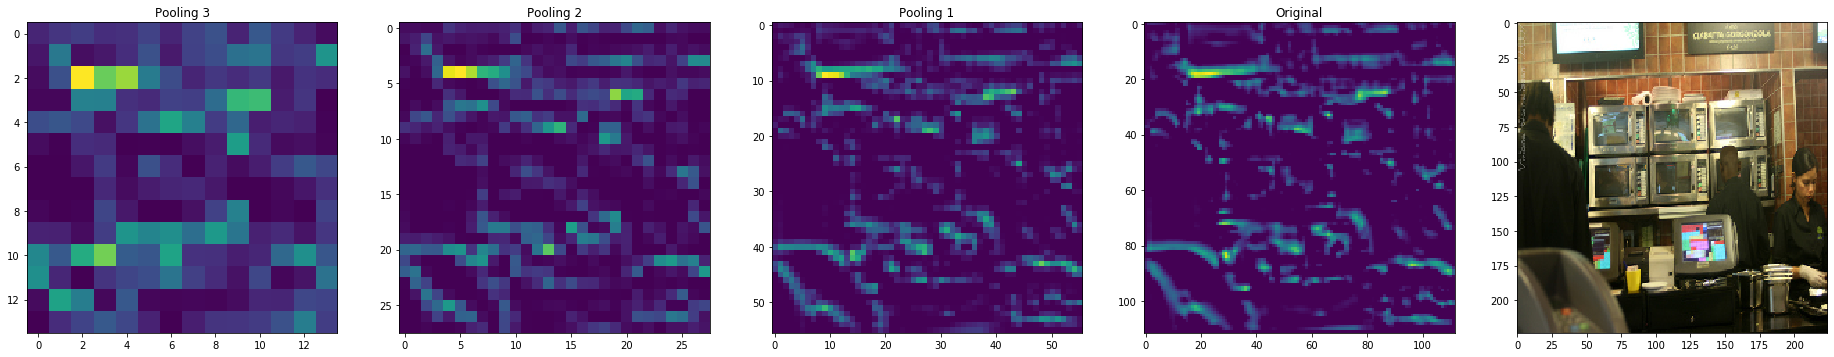

In [21]:
num = 66
plt.figure(figsize=(5, 5)) 
plt.subplot(151)
plt.imshow(layer_3[0][num])
plt.title("Pooling 3")
plt.subplot(152)
plt.imshow(layer_2[0][num])
plt.title("Pooling 2")
plt.subplot(153)
plt.imshow(layer[0][num])
plt.title("Pooling 1")
plt.subplot(154)
plt.imshow(or_layer[0][num])
plt.title("Original")
plt.subplot(155)
plt.imshow(img)
plt.subplots_adjust(left=0, bottom=0, right=5, top=10, wspace=0.2, hspace=0.2)
plt.show()